## Strategy

> To trade support and resistance levels as well as some well known chart patterns

### *Signals*

> Bounce on resistance / pass support for 2 days = sell

> Bounce on support / pass resistance for 2 days = buy

> Head and shoulders trade


In [470]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime
from scipy.signal import argrelextrema


In [471]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df.head()


,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Series 8,Series 9,Series 10,...,Series 20,Series 21,Series 22,Series 23,Series 24,Series 25,Series 26,Series 27,Series 28,Series 29
Day,,,,,,,,,,,,,,,,,,,,,
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.172920,100.589993,103.823464,98.644063,99.750482,106.614321,101.767999,100.732626,99.952576,100.227093,...,101.568951,99.730607,99.673906,99.409461,99.113705,100.012563,100.311565,99.887188,96.556886,97.922078
2,98.579911,98.767737,107.058757,97.936942,99.220660,110.602917,100.681776,100.383846,99.617067,100.246064,...,106.193229,101.541426,99.977798,99.577298,99.783831,99.682467,100.366287,99.902872,95.608782,100.000000
3,98.397809,97.087379,107.352843,100.000000,99.251805,113.424191,102.651998,101.569981,98.659381,101.230321,...,106.936416,100.938414,99.278429,99.055138,100.875486,99.637414,100.767880,100.216365,95.109780,100.000000
4,99.051233,99.716206,105.587978,99.703996,99.407530,113.715275,100.710685,101.081407,99.760755,101.040888,...,107.018993,101.448655,99.979185,99.602163,100.162127,100.379047,101.058262,100.323414,90.469062,99.480519


In [472]:
# Identifying turning points

def get_max_min(prices, smoothing, window_range):
    
    smooth_prices = prices.rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range].idxmin())  
            
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['Day'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')
    
    return max_min, maxima, minima

smoothing = 3
window = 10

[minmax, maxima, minima] = get_max_min(df['Series 6'], smoothing, window)
minmax.head()

,date,Series 6
day_num,,
6,6,115.466257
11,11,114.298936
14,14,102.334642
19,19,105.447000
22,22,113.230135


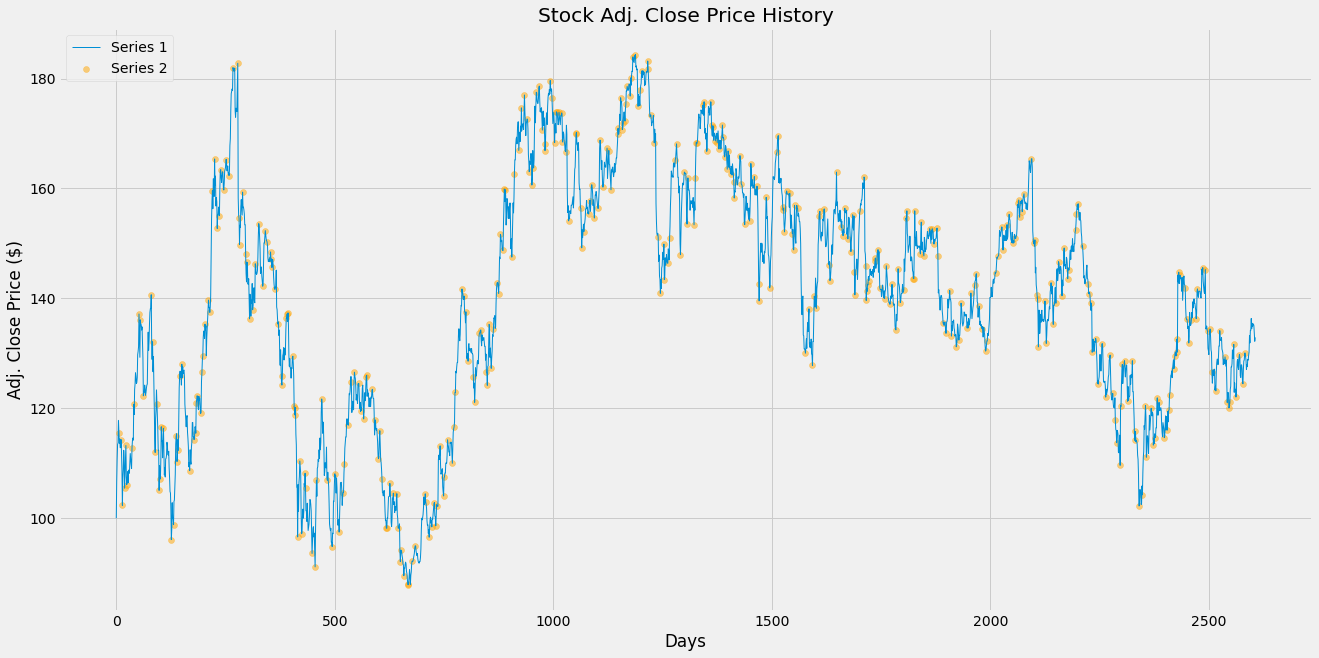

In [473]:
# plotting turning points
#Visualise the data

plt.figure(figsize=(20, 10))
plt.plot(df.reset_index()['Series 6'], linewidth = 1)
plt.scatter(minmax.index, minmax['Series 6'].values, color='orange', alpha=.5)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()


## Strategy 2

#### Identifying levels of support and resistance

In [709]:
# import necessary libraries
import matplotlib.dates as mpl_dates

start = 0
end = 720

# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')

# df selected for testing purposes
data = df['Series 22'].iloc[0:]


In [706]:
#method 1: fractal candlestick pattern
# determine bullish fractal 

def is_support(df,i):  
    
    cond1 = df[i] < df[i-1]   
    cond2 = df[i] < df[i+1]   
    # cond3 = df[i+1] < df[i+2]   
    # cond4 = df[i-1] < df[i-2]  
    return (cond1 and cond2) # and cond3 and cond4) 

# determine bearish fractal
def is_resistance(df,i):  
    
    cond1 = df[i] > df[i-1]   
    cond2 = df[i] > df[i+1]   
    #cond3 = df[i+1] > df[i+2]   
    #cond4 = df[i-1] > df[i-2]  
    return (cond1 and cond2) # and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df): 
    
    ave =  np.mean(abs(df.iloc[2::] - df.iloc[0:-2]))    
    return np.sum([abs(value-level)<ave for _,level in levels])==0

# a list to store resistance and support levels
def leveler(series, start_day, end_day):
    
    levels = []
    lows = []
    highs = []

    data = df[series][start_day:end_day]

    for i in range(data.index[0]+2, data.shape[0] + data.index[0] - 2):  

        if is_support(data, i):    
            low = data[i]    
            if is_far_from_level(low, levels, data):      
                levels.append((i, low)) 
                lows.append((i, low))
        elif is_resistance(data, i):    
            high = data[i]    
            if is_far_from_level(high, levels, data):      
                levels.append((i, high))
                highs.append((i, high))
                
    return levels, lows, highs


In [738]:
# for visualization
def plot_all(levels, df):    
    fig, ax = plt.subplots(figsize=(15, 9))   
    ax.plot(df, linewidth=2, alpha=0.8, label=series)        
    
    for level in levels:        
        plt.hlines(level[1], xmin = df.reset_index()['Day'][level[0]-start], xmax = 
            max(df.reset_index()['Day']), colors='red', linestyle='--', linewidth=1)    
        plt.legend()
        
    plt.show()


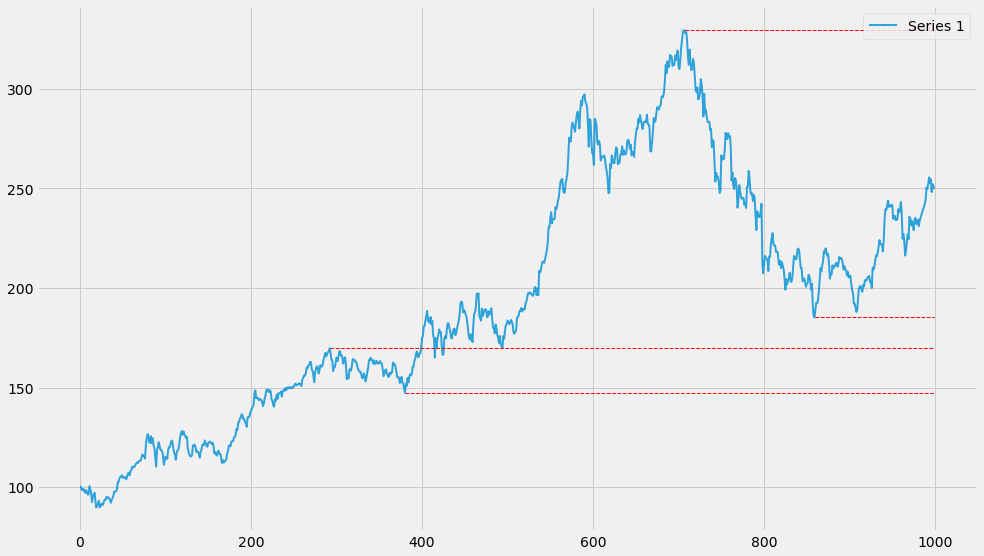

In [742]:
#method 2: window shifting method
#using the same symbol as the first example above

# window used to calculate supports and resistance
window = 5

def levelerv2(series, window, start, end):
    
    pivots = []
    max_list = []
    min_list = []
    
    data = df[series][start:end] 
    
    for i in range(window, len(data)-window):

        # taking a window of 9 candles
        high_range = data[i-window:i+window-1]
        current_max = high_range.max()

        # if we find a new maximum value, empty the max_list 
        if current_max not in max_list:
            max_list = []
        max_list.append(current_max)

        # if the maximum value remains the same after shifting 5 times
        if len(max_list)==window and is_far_from_level(current_max,pivots,data):
            pivots.append((high_range.idxmax(), current_max))

        low_range = data[i-window:i+window]
        current_min = low_range.min()

        if current_min not in min_list:
            min_list = []
        min_list.append(current_min)

        if len(min_list)==window and is_far_from_level(current_min,pivots,data):
            pivots.append((low_range.idxmin(), current_min))
    
    return pivots


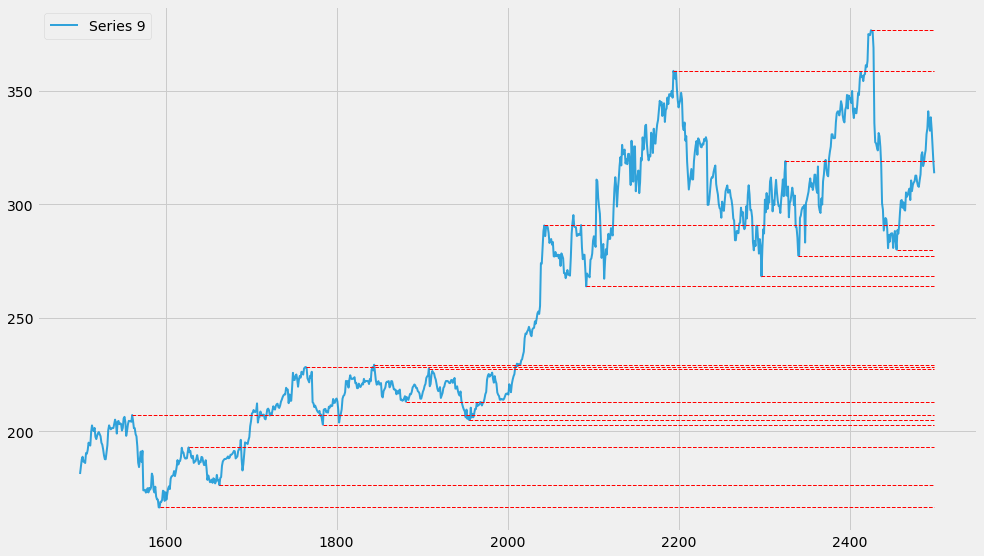

In [758]:
# call function

series = 'Series 9'
start = 1500
end = 2500

plot_all(levelerv2(series, 30, start, end), df[series][start:end])

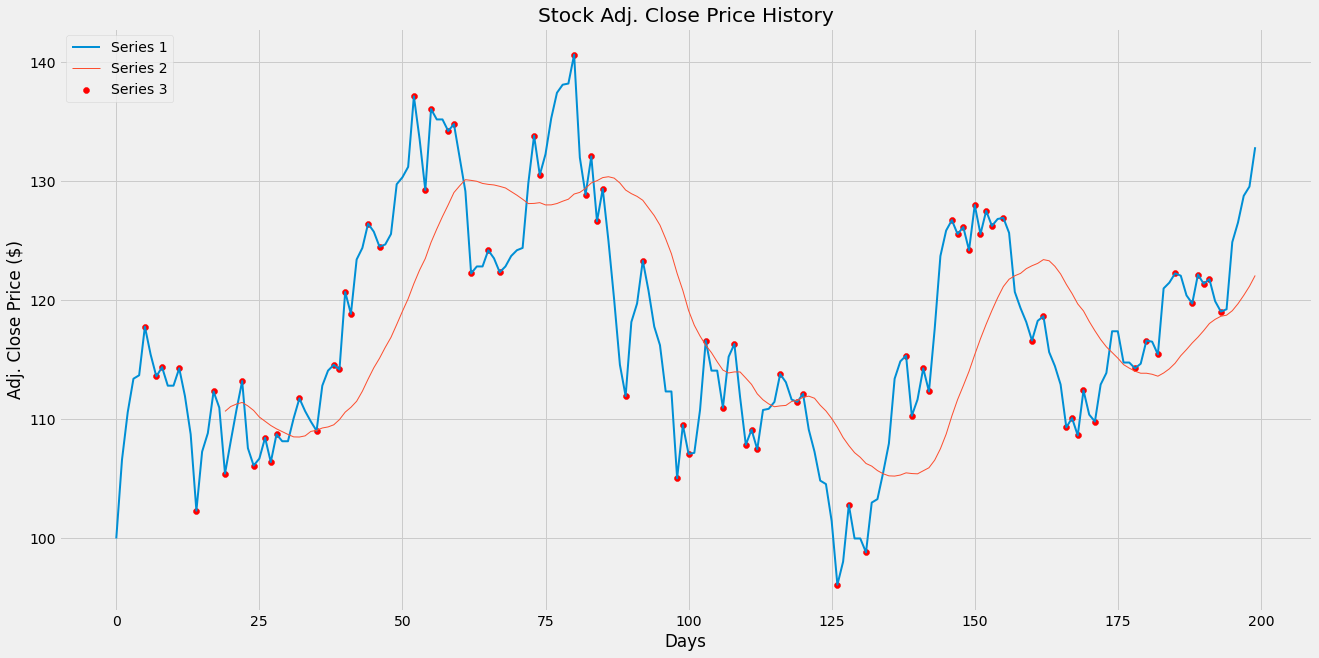

In [599]:
# plotting turning points
#Visualise the data
start_day = 0
end_day = 200
series = 'Series 6'

data = df[series][start_day:end_day]

pivot = pd.DataFrame(leveler(series, start_day, end_day)[0])

plt.figure(figsize=(20, 10))
plt.plot(data, linewidth = 2)
plt.plot(data.rolling(window=20).mean(), linewidth=1)
plt.scatter(pivot[0], pivot[1], color='red', alpha=1)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()

### Strategy

> Fit curve to peaks and troughs

> Look ahead 3 days to t

In [901]:
# imports 
from numpy import arange
from scipy.optimize import curve_fit
 



#### Fitting Sin Curve

In [920]:
# define the true objective function
def objectives(x, a, b, c, d):
    return a * np.sin(b - x) + c * x**2 + d

def fit_sin_curve(series, vision, window, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(levelerv2(series, window, span[0], span[1]))
    else: 
        data1 = df[series][span[0]:span[1]].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objectives, x, y)
    # summarize the parameter values
    a, b, c, d = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objectives(x_line, a, b, c, d)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objectives(x_line_f, a, b, c, d)

    return x_line, y_line, x_line_f, y_line_f




#### Fitting 5th Degree Polynomial

In [921]:
# fit a 5th degree polynomial to the economic data
# define the true objective function
def objective5(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

def fit_pent_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective5, x, y)
    # summarize the parameter values
    a, b, c, d, e, f = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective5(x_line, a, b, c, d, e, f)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective5(x_line_f, a, b, c, d, e, f)

    return x_line, y_line, x_line_f, y_line_f


#### Fitting 4th Degree Polynomial

In [922]:
# define the true objective function
def objective4(x, a, b, c, d, e):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e

def fit_quad_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective4, x, y)
    # summarize the parameter values
    a, b, c, d, e = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective4(x_line, a, b, c, d, e)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective4(x_line_f, a, b, c, d, e)

    return x_line, y_line, x_line_f, y_line_f


#### Fitting 3rd Degree Polynomial

In [923]:
# define the true objective function
def objective3(x, a, b, c, d):
    return (a * x) + (b * x**2) + (c * x**3) + d

def fit_tri_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective3, x, y)
    # summarize the parameter values
    a, b, c, d = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective3(x_line, a, b, c, d)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective3(x_line_f, a, b, c, d)

    return x_line, y_line, x_line_f, y_line_f


#### Fitting 2nd Degree Polynomial

In [924]:
# define the true objective function
def objective2(x, a, b, c):
    return (a * x) + (b * x**2) + c

def fit_bi_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective2, x, y)
    # summarize the parameter values
    a, b, c = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective2(x_line, a, b, c)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective2(x_line_f, a, b, c)

    return x_line, y_line, x_line_f, y_line_f


## Plotting / Testing Fits

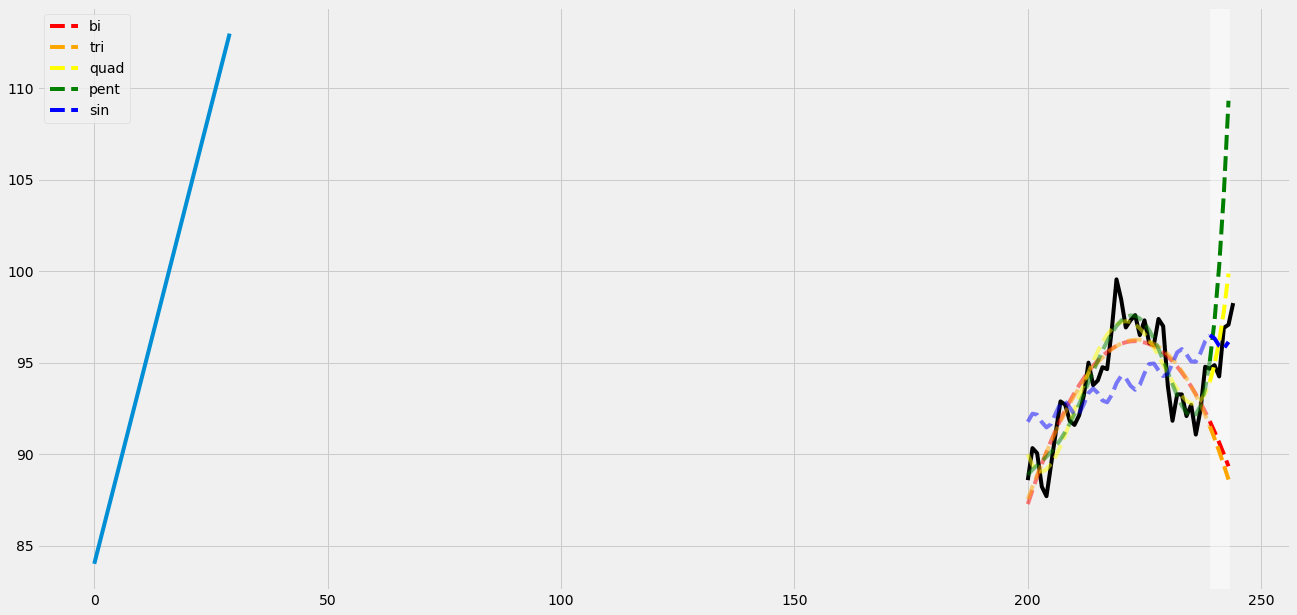

In [943]:
# calling different fitted curves
# calling function

series = 'Series 7'    # series used 
vision = 5            # how far ahead to predict
span1 = [200, 240]   # window to predict over
window = 30            # used in sin fit for levelerv2 function (higher = more substantial peaks)
option = 1             # 0 = fits for data points, 1 = fits for turning points

# get data
[x_line1, y_line1, x_line_f, y_line_f1] = fit_bi_curve(series, vision, span1, option)
[x_line2, y_line2, x_line_f, y_line_f2] = fit_tri_curve(series, vision, span1, option)
[x_line3, y_line3, x_line_f, y_line_f3] = fit_quad_curve(series, vision, span1, option)
[x_line4, y_line4, x_line_f, y_line_f4] = fit_pent_curve(series, vision, span1, option)
[x_line5, y_line5, x_line_f, y_line_f5] = fit_sin_curve(series, vision, window, span1, option)

# create a line plot for the mapping function
plt.figure(figsize=(20, 10))
plt.plot(df[series][span1[0]:span1[1]+vision], color='black')

# plot fitted curve
plt.plot(x_line1, y_line1, '--', color='red', alpha=.5)
plt.plot(x_line2, y_line2, '--', color='orange', alpha=.5)
plt.plot(x_line3, y_line3, '--', color='yellow', alpha=.5)
plt.plot(x_line4, y_line4, '--', color='green', alpha=.5)
plt.plot(x_line5, y_line5, '--', color='blue', alpha=.5)
# plot prediction
plt.plot(x_line_f, y_line_f1, '--', label='bi', color='red')
plt.plot(x_line_f, y_line_f2, '--', label='tri', color='orange')
plt.plot(x_line_f, y_line_f3, '--', label='quad', color='yellow')
plt.plot(x_line_f, y_line_f4, '--', label='pent', color='green')
plt.plot(x_line_f, y_line_f5, '--', label='sin', color='blue')
# separator
plt.plot(range(int(np.round(min(y_line_f1[-1], y_line_f2[-1], y_line_f3[-1], y_line_f4[-1], y_line_f5[-1]))-5), \
              int(np.round(max(y_line_f1[-1], y_line_f2[-1], y_line_f3[-1], y_line_f4[-1], y_line_f5[-1]))+5)))
plt.axvspan(x_line_f[0], x_line_f[-1], alpha=0.5, color='white')

plt.legend()
plt.show()

Finished prediction 0 of 190
Finished prediction 1 of 190
Finished prediction 2 of 190
Finished prediction 3 of 190
Finished prediction 4 of 190
Finished prediction 5 of 190
Finished prediction 6 of 190
Finished prediction 7 of 190
Finished prediction 8 of 190
Finished prediction 9 of 190
Finished prediction 10 of 190
Finished prediction 11 of 190
Finished prediction 12 of 190
Finished prediction 13 of 190
Finished prediction 14 of 190
Finished prediction 15 of 190
Finished prediction 16 of 190
Finished prediction 17 of 190
Finished prediction 18 of 190
Finished prediction 19 of 190
Finished prediction 20 of 190
Finished prediction 21 of 190
Finished prediction 22 of 190
Finished prediction 23 of 190
Finished prediction 24 of 190
Finished prediction 25 of 190
Finished prediction 26 of 190
Finished prediction 27 of 190
Finished prediction 28 of 190
Finished prediction 29 of 190
Finished prediction 30 of 190
Finished prediction 31 of 190
Finished prediction 32 of 190
Finished prediction 

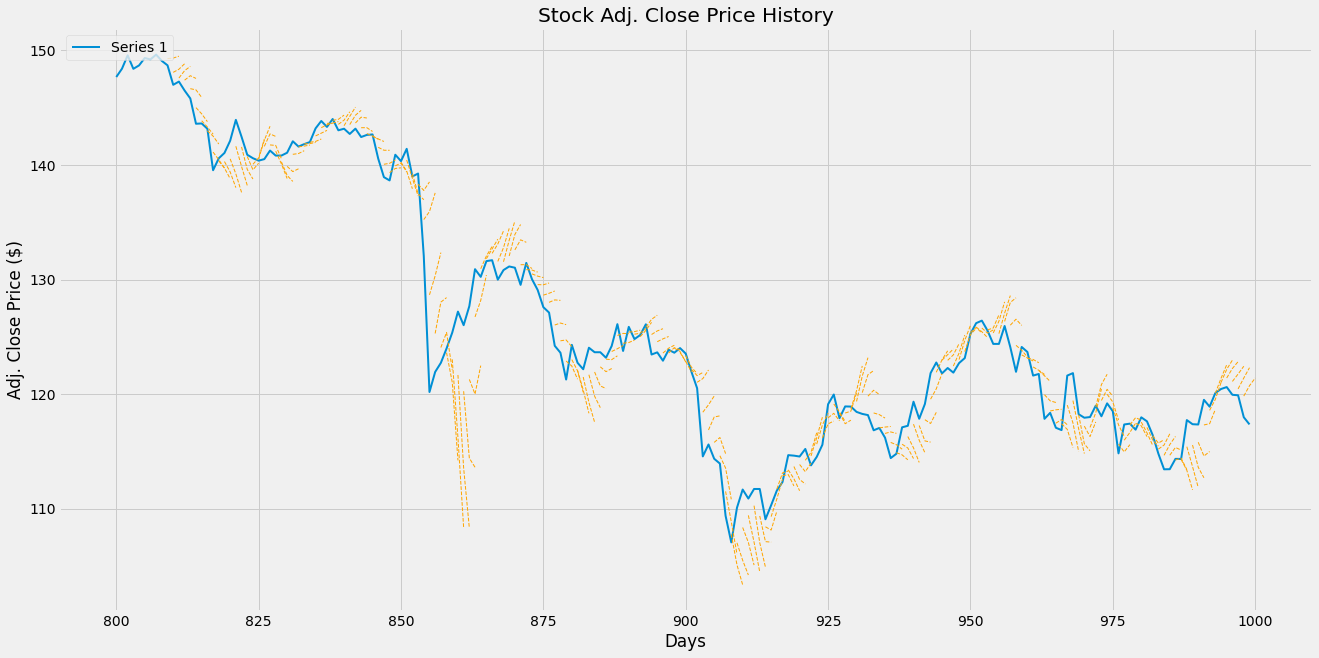

In [673]:
# testing across whole series
def crystal_ball(series, vision, window, start, end, option, predictor):
    
    # series - data used
    # vision - how far ahead to predict
    # window - number of values used in curve fitting
    # start - observation period start
    # end - observation period end
    # option - used in predictor (0 uses turning point data, 1 uses price data)
    # predictor - type of interpolation (0 uses 4th deg poly, 1 uses sin)
    
    data1 = df[series][start:end]
    
    # plot initial curve
    plt.figure(figsize=(20, 10))
    plt.plot(data1, linewidth = 2)
    plt.title('Stock Adj. Close Price History')
    plt.xlabel('Days')
    plt.ylabel('Adj. Close Price ($)')
    plt.legend(df, loc='upper left')
    
    # plot guess per time step
    for i in range(start, end-window):
        
        span = [i, i+window]
        
        if predictor == 0:
            [x_line, y_line, x_line_f, y_line_f] = fit_quad_curve(series, vision, span, option)
        elif predictor == 1:
            [x_line, y_line, x_line_f, y_line_f] = fit_sin_curve(series, vision, span, option)
        
        # create a line plot for the mapping function
        plt.plot(x_line_f, y_line_f, '--', color='orange', linewidth=1)
        
        print('Finished prediction %.d of %.d' % (i-start, end-window-start))

# call function

crystal_ball('Series 21', 3, 10, 800, 1000, 1, 0)
        
        

In [596]:
data

Day
0      100.000000
1      101.767999
2      100.681776
3      102.651998
4      100.710685
          ...    
195     85.299180
196     87.045060
197     87.784164
198     87.941308
199     88.843367
Name: Series 7, Length: 200, dtype: float64

In [632]:
df

,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Series 8,Series 9,Series 10,...,Series 20,Series 21,Series 22,Series 23,Series 24,Series 25,Series 26,Series 27,Series 28,Series 29
Day,,,,,,,,,,,,,,,,,,,,,
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.172920,100.589993,103.823464,98.644063,99.750482,106.614321,101.767999,100.732626,99.952576,100.227093,...,101.568951,99.730607,99.673906,99.409461,99.113705,100.012563,100.311565,99.887188,96.556886,97.922078
2,98.579911,98.767737,107.058757,97.936942,99.220660,110.602917,100.681776,100.383846,99.617067,100.246064,...,106.193229,101.541426,99.977798,99.577298,99.783831,99.682467,100.366287,99.902872,95.608782,100.000000
3,98.397809,97.087379,107.352843,100.000000,99.251805,113.424191,102.651998,101.569981,98.659381,101.230321,...,106.936416,100.938414,99.278429,99.055138,100.875486,99.637414,100.767880,100.216365,95.109780,100.000000
4,99.051233,99.716206,105.587978,99.703996,99.407530,113.715275,100.710685,101.081407,99.760755,101.040888,...,107.018993,101.448655,99.979185,99.602163,100.162127,100.379047,101.058262,100.323414,90.469062,99.480519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,1068.632552,1336.228529,250.467832,628.636139,520.120714,135.336090,152.596035,975.221144,387.600334,178.429607,...,36.052849,133.667844,76.928467,80.455647,118.244704,387.835836,284.502070,269.421370,63.223553,49.350649
2603,1089.834425,1395.646004,254.419892,634.847737,521.588464,135.049484,153.458825,975.884108,390.275202,177.730774,...,37.869529,134.769500,76.980504,80.721701,118.487895,390.846986,285.961041,270.422318,63.123752,49.350649
2604,1089.421252,1396.415235,253.909722,636.683560,521.767458,133.762744,153.093788,972.127936,391.971857,179.025088,...,36.862097,134.771284,77.517519,81.310996,118.278210,390.163835,285.970750,270.647848,67.015968,48.831169
